# Quantum Counting



Dada una función binaria $f:\{0, 1\}^{n} \rightarrow \{0, 1\}$, Quantum Counting permite estimar, usando Quantum Phase Estimation (QPE) y el operador de Grover $G = A O_f$, la cantidad $M$ de elementos tales que $f(x) = 1$. 

La idea es aplicar QPE al operador de Grover $G = A O_f$. Comenzando con el estado $\ket{+}^{\otimes n}$, que se puede escribir como:

$$
\ket{+}^{\otimes n} = \frac{\sqrt{N - M}}{\sqrt{N}} \ket{\alpha} + \frac{\sqrt{M}}{\sqrt{N}} \ket{\beta}
$$

Vimos que, en el plano generado por $\ket{\alpha}$ y $\ket{\beta}$, los valores propios de $G$ son:

$$
\lambda = e^{\pm i \theta}
$$

donde $\theta = 2\arcsin\!\left(\frac{\sqrt{M}}{\sqrt{N}}\right)$, de modo que 
$\sin^2\!\left(\frac{\theta}{2}\right) = \frac{M}{N}$.



## Aplicación de QPE

QPE aplicado a $G$ nos va a dar una estimación $\phi_{\text{QPE}}$ de $\pm \theta/(2\pi)$, de forma que podemos recuperar $M$ notando que:

- Si $\phi_{\text{QPE}}$ está asociado a $+\theta$, entonces mediremos una aproximación $\phi_{\text{QPE}} \approx \theta /(2\pi) < 1/2$ (recordar que $\theta < \pi$)

$$\theta/2 \approx \pi \phi_{\text{QPE}}$$
$$M \approx \sin^2 (\pi \phi_{\text{QPE}})N$$

- Si $\phi_{\text{QPE}}$ está asociado a $-\theta$, entonces mediremos una aproximación $\phi_{\text{QPE}} \approx (2\pi - \theta)/(2\pi) = 1 -  \theta/(2\pi) > 1/2$.

$$\theta/2 \approx \pi - \pi \phi_{\text{QPE}}$$
$$M \approx \sin^2(\pi - \pi \phi_{\text{QPE}})N$$

### Nuestra implementación

En nuestro ejemplo de Grover implementamos $-G$. El efecto de esto es que las fases tienen un desplazamiento de $\pi$. Los valores propios del operador $(-G)$ serán:

$$\lambda = e^{i(\pm \theta + \pi)}$$

- Si $\phi_{\text{QPE}}$ está asociado a $+\theta$, entonces mediremos una aproximación de $\phi_{\text{QPE}} \approx (\theta + \pi)/(2\pi) = \theta/(2\pi) + 1/2$

$$\theta/2 \approx \pi \phi_{\text{QPE}} - \pi/2$$
$$M \approx \sin^2(\pi \phi_{\text{QPE}} - \pi/2)N$$

- Si $\phi_{\text{QPE}}$ está asociado a $-\theta$, entonces mediremos una aproximación de $\phi_{\text{QPE}} \approx (-\theta + \pi)/(2\pi) = -\theta/(2\pi) + 1/2$

$$\theta/2 \approx -\pi \phi_{\text{QPE}} + \pi/2$$
$$M \approx \sin^2(-\pi \phi_{\text{QPE}} + \pi/2)N$$



## Análisis del error:

Usando $t$ qubits, donde:

$$t = m + \left\lceil \log_2\left( 2 + \frac{1}{2\varepsilon} \right) \right\rceil$$

nos aseguramos de medir $\phi_{QPE}$ de forma correcta (con precisión de al menos $t$ bits) con una probabilidad de al menos $1 - \varepsilon$.

$$\left| \hat{\phi}_{QPE} - \phi_{QPE} \right| < 2^{-m}$$
$$\left| \pi \hat{\phi}_{QPE} - \pi \phi_{QPE} \right| < \pi 2^{-m}$$
$$\left| \left( \pi \hat{\phi}_{QPE} - \pi/2 \right) - \left(\pi \phi_{QPE} - 2\pi \right)\right| < \pi 2^{-m}$$
$$\left| \hat{\theta} /2  - \theta / 2 \right| < \pi 2^{-m}$$

Se puede demostrar, por el teorema del valor medio, que:

$$\left| \sin^{2}(x) - \sin^{2}(y) \right| \leq |x - y| \hspace{10pt} \forall x, y \in \mathbb{R}$$

Por tanto:

$$\left| \hat{M} - M \right| < \pi N2^{-t} = \pi 2^{-m + n}$$

Como $\pi / 8 \approx 0.3927$, podemos asegurar (con probabilidad de al menos $1 - \varepsilon$) medir correctamente $M$ luego de redondear $\hat{M}$ al entero más cercano, tomando $m = n + 3$.


In [25]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.primitives import StatevectorSampler
from qiskit.circuit.library import ZGate

import math

## Ejemplo:

Implementamos $f: \{ 0, 1 \}^{\otimes 4} \rightarrow \{ 0, 1 \}$ que marca los elementos $0111$ y $1111$. El operador $O_f$ se puede implementar con una compuerta $Z$ controlada por los tres primeros qubits.

- $M = 2$
- $N = 2^{4} = 16$
- $\theta = \arcsin(\sqrt{2}/4) \approx 0.7227 = 41.41°$


In [30]:
def iqft(qc, qr, qubits_list = None, swaps = False):
    '''
    Append the Inverse QFT (IQFT) operator to a quantum circuit qc.

    Args:
        - qc (QuantumCircuit): Qiskit Quantum Circuit
        - qr (QuantumRegister): Qiskit Quantum Register in which to apply the IQFT
        - qubits_list (int[]): List indicating the order of the qubits. If None, we select the natural order (from zero to the number of qubits in qr)
        - swaps (bool): If True, perform swap operations before the IQFT

    Returns:
        - None
    '''

    if (qubits_list == None):
        qubits_list = [i for i in range(len(qr))]

    n = len(qubits_list)


    if swaps:
        for i in range(int(n/2)):
            qc.swap(qr[qubits_list[i]], qr[qubits_list[(n-1)-i]])


    for i in range(n):

        k = (n - 1) - i
        for j in range(k + 1, n):
            phase = - 2 * math.pi / (2**(2 + j - (k + 1)))
            qc.cp(phase, qr[qubits_list[j]], qr[qubits_list[k]])

        qc.h(qubits_list[k])

    
    

    return


def controlled_u(qc, qr, control, exponent, log_M): 
    '''
    Append the gate controlled-U^exponent on the register qr, controlled by the qubit control. 
    U = -G, where G is the Grover operator corresponding to a function that marks M = 2**log_M 
    values. In particular, it marks the values with the first m-log_M qubits in |1>, where m is the total number of qubits in qr

    Example: For m = 5 and log_M = 2, it marks: 00111, 01111, 10111, 11111.

    Args:
        - qc (QuantumCircuit): Qiskit Quantum Circuit
        - qr (QuantumRegister): Qiskit Quantum Register where the U^exponent gate is applied
        - control (int or QuantumRegister[i]): Control qubit
        - exponent (int): Exponent for the gate

    Returns:
        - None
    '''


    m = len(qr)

    new_qr = QuantumRegister(m)
    new_qc = QuantumCircuit(new_qr)
    
    for _ in range(exponent):
        # Oracle: multicontrolled Z in the first m - log_M qubits
        if m == log_M + 1:
            new_qc.z(new_qr[0])

        else:
            new_qc.append(ZGate().control(m-log_M - 1), new_qr[0:m-log_M])
        
        # Append diffusion operator to the principal qubits
        new_qc.h(new_qr)
        new_qc.x(new_qr)
        new_qc.append(ZGate().control(m - 1), new_qr)
        new_qc.x(new_qr)
        new_qc.h(new_qr)

    G = new_qc.to_gate(label = f"(-G)^({exponent})")

    qc.append(G.control(1), [control] + [q for q in qr])

    return



def phase_estimation(qc, pr, sc, controlled_u):
    '''
    Append the Phase Estimation procedure to the quantum circuit qc.

    Args:
        - qc (QuantumCircuit): Qiskit Quantum Circuit
        - pr (QuantumRegister): Principal register. The first register in the algorithm.
        - sc (QuantumRegister): Second register.
        - controlled_u (Function): Function that appends the controlled U^exponent gate to the circuit.

    Returns:
        - None
    '''

    t = len(pr)

    for i in range(t):
        controlled_u(qc, sc, pr[(t-1) - i], 2**i)

    ## Apply inverse Fourier Transform with swaps = True
    iqft(qc, pr, swaps=True)

    return

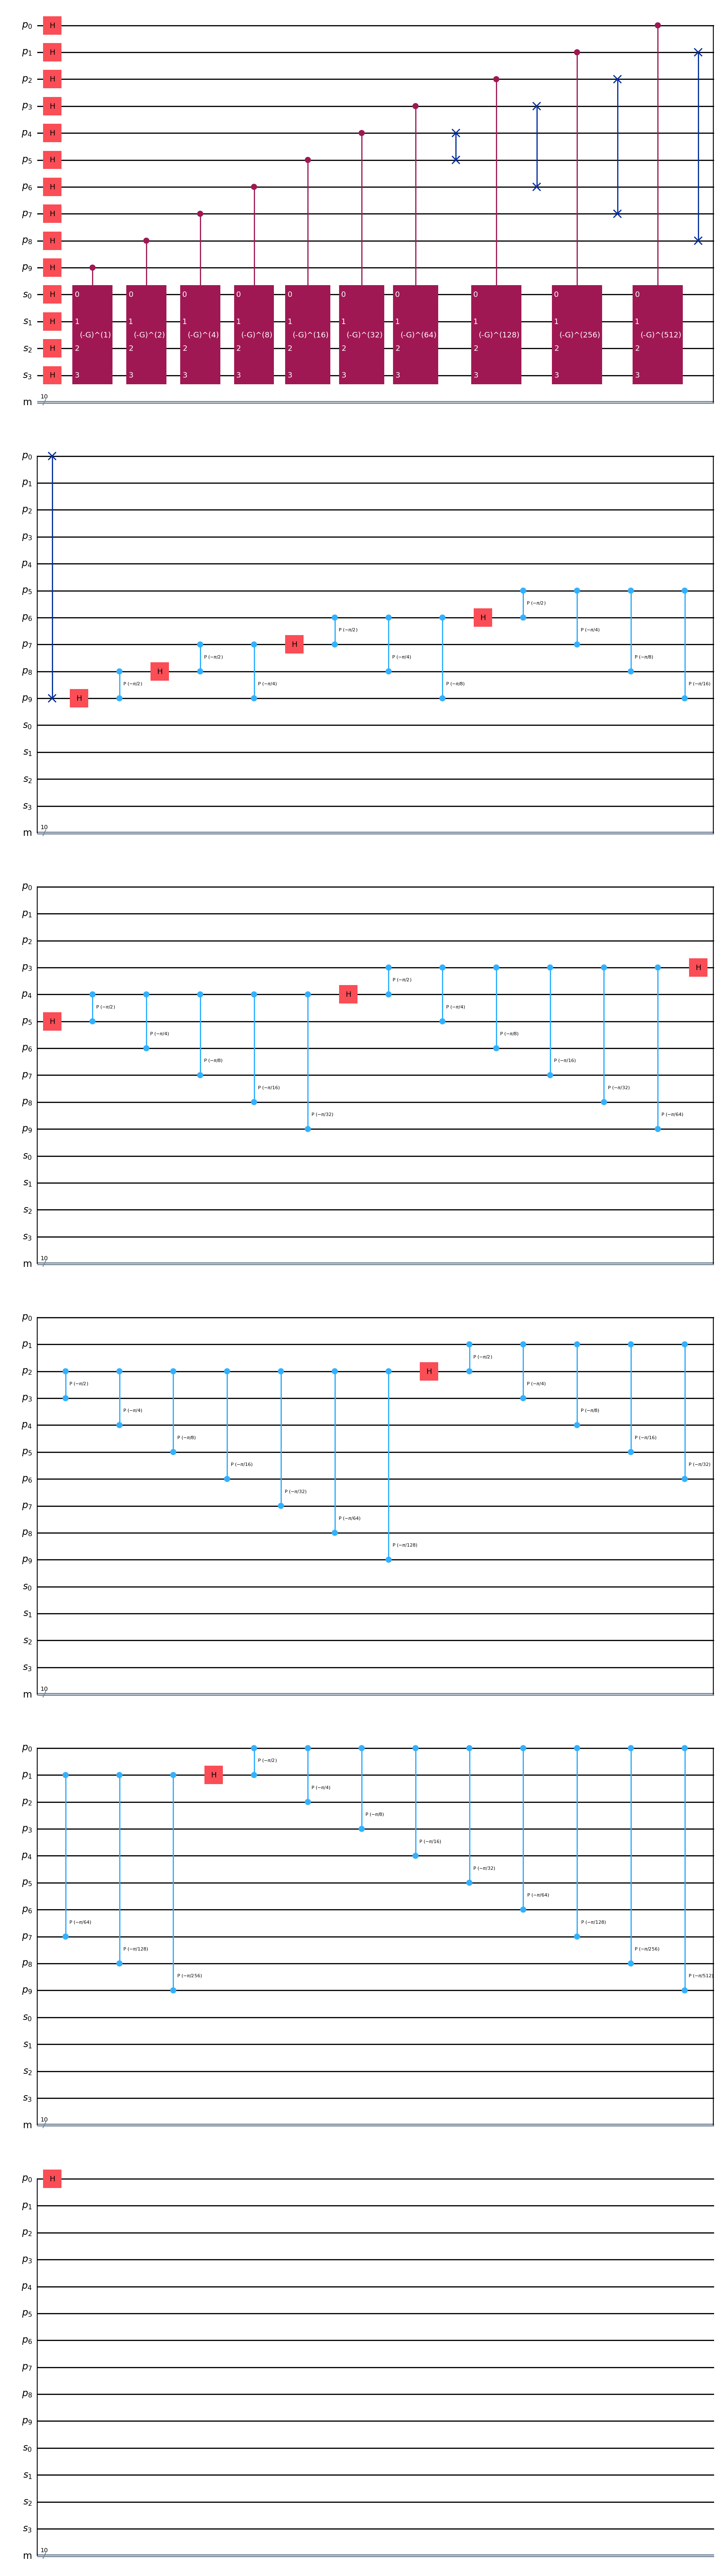

In [41]:
tol = 7 # Desired precision (m)
epsilon = 0.1 # Maximum probability of error desired

n = 4
t = tol + int(math.log2(2 + 1/(2*epsilon))) + 1 

pr = QuantumRegister(t, 'p')  
sc = QuantumRegister(n, 's')
cr = ClassicalRegister(t, 'm')
qc = QuantumCircuit(pr, sc, cr)

qc.h(sc)
qc.h(pr)

# Set log_M = 1 in controlled_u function to get M = 2
phase_estimation(qc, pr, sc, lambda qc, qr, control, exponent, log_M = 1: controlled_u(qc, qr, control, exponent, log_M ))

qc.draw("mpl")

In [ ]:
# Simulation of circuit:
qc.measure(pr, cr)

# Instantiate a new statevector simulation based sampler object.
sampler = StatevectorSampler()
shots = 100000
 

job = sampler.run([qc], shots=shots)
 
# Extract the result for the 0th pub (this example only has one pub).
result = job.result()[0]
counts = result.data.m.get_counts()

prob = 0

values = {}
M_values = {}
for i in range(0, 2**n + 1):
    M_values[i] = 0

predicted = '0'*t
counts_predicted = 0

for key in counts.keys():
    # Qiskit will give the qubits in reverse order in the result. We have to reverse the order to get the value in the order that we want
    key_r = key[::-1]
    values[int(key_r, 2)/2**t] = counts[key]

    phi_QPE = (int(key_r, 2)/2**t)
    M = round(math.sin(math.pi*phi_QPE - math.pi/2)**2 * 2**n)
    M_values[M] += counts[key]

    if(counts[key] > counts_predicted):
        counts_predicted = counts[key]
        predicted = key_r


print(f" > Obtained approximation phase with {counts_predicted} measures over {shots} shots: 0b0.{predicted} = {int(predicted, 2)/2**t}")
print(f" > Tolerance: {1/2**tol}")

 > Obtained approximation phase with 43419 measures over 100000 shots: 0b0.0110001010 = 0.384765625
 > Tolerance: 0.0078125


In [42]:
phi_QPE = (int(predicted, 2)/2**t)

if phi_QPE < 1/2:
    # Associated to phase -theta
    theta = -2*math.pi*phi_QPE + math.pi

else:
    # Associated to phase +theta
    theta = 2*math.pi*phi_QPE - math.pi

print(f" > Angle: {theta} radians = {theta * 180 / math.pi}°")

 > Angle: 0.7240389318820228 radians = 41.484375000000014°


In [38]:
print(f" > Estimation of M: {math.sin(math.pi*phi_QPE - math.pi/2)**2 * 2**n}")
print(f" > Estimation of M (rounded to nearest integer): {round(math.sin(math.pi*phi_QPE - math.pi/2)**2 * 2**n)}")

 > Estimation of M: 2.0069088438123264
 > Estimation of M (rounded to nearest integer): 2


In [23]:
class bcolors:
    HEADER = '\033[95m'
    OKBLUE = '\033[94m'
    OKCYAN = '\033[96m'
    OKGREEN = '\033[92m'
    WARNING = '\033[93m'
    FAIL = '\033[91m'
    ENDC = '\033[0m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'

In [40]:
for key in M_values.keys():
    if M_values[key]/shots >= 1-epsilon:
        print(f"{bcolors.OKGREEN} > measures with M = {key}: {(M_values[key]/shots * 100):.3f} %{bcolors.ENDC}")

    else:
        print(f" > measures with M = {key}: {(M_values[key]/shots * 100):.3f} %")

 > measures with M = 0: 0.045 %
 > measures with M = 1: 0.197 %
 > measures with M = 2: 99.483 %
 > measures with M = 3: 0.170 %
 > measures with M = 4: 0.043 %
 > measures with M = 5: 0.014 %
 > measures with M = 6: 0.010 %
 > measures with M = 7: 0.004 %
 > measures with M = 8: 0.008 %
 > measures with M = 9: 0.005 %
 > measures with M = 10: 0.001 %
 > measures with M = 11: 0.006 %
 > measures with M = 12: 0.004 %
 > measures with M = 13: 0.004 %
 > measures with M = 14: 0.001 %
 > measures with M = 15: 0.001 %
 > measures with M = 16: 0.004 %
